In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score,recall_score,balanced_accuracy_score, precision_score,f1_score

In [2]:
df = pd.read_csv('../data/cleaning_data_phase2.csv.zip')

In [3]:
df.head()

,_michd,_sex,genhlth,physhlth,menthlth,addepev3,checkup1,_totinda,_rfhype6,cholmed3,...,_metstat,_imprace,_age80,_educag,ftjuda2_,frutda2_,grenda1_,frnchda_,potada1_,vegeda2_
0,No,Female,Poor,20.0,10.0,No,Within past 2 years (1 year but < 2 years ago),No physical activity or exercise in last 30 days,No,Yes,...,yes,white,70.0,highschool,5.397605e-79,100.0,5.700000e+01,4.300000e+01,14.0,100.0
1,Yes,Female,Good,0.0,0.0,No,Within past year (anytime < 12 months ago),Had physical activity or exercise,Yes,Yes,...,yes,black,67.0,graduated college,5.397605e-79,100.0,1.400000e+01,5.397605e-79,14.0,100.0
2,Yes,Female,Very good,0.0,0.0,No,Within past year (anytime < 12 months ago),No physical activity or exercise in last 30 days,Yes,No,...,yes,black,72.0,highschool,5.397605e-79,100.0,5.397605e-79,1.400000e+01,14.0,43.0
3,No,Female,Very good,0.0,10.0,No,Within past year (anytime < 12 months ago),Had physical activity or exercise,Yes,No,...,yes,white,62.0,highschool,7.100000e+01,43.0,1.000000e+01,5.700000e+01,27.0,71.0
4,Yes,Male,Poor,30.0,0.0,No,Within past year (anytime < 12 months ago),Had physical activity or exercise,No,Yes,...,no,other race,76.0,no highschool,5.397605e-79,100.0,1.000000e+02,2.900000e+01,29.0,100.0


In [6]:
X= df.drop(columns = ['_michd','_state'])
y = df['_michd']

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)

In [8]:
categorical = X.select_dtypes('object').columns
numerical = X.columns.drop(categorical)

In [9]:
ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False) 
si_numerical = SimpleImputer(strategy='median')  

In [10]:
ctx = ColumnTransformer(
transformers = [
    ('ohe',ohe,categorical),
    ('si_num',si_numerical,numerical)
])

In [11]:
X_train_ohe_imputed = ctx.fit_transform(X_train)

/Users/markbiernacki/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
X_test_ohe_imputed = ctx.transform(X_test)

In [13]:
rf = RandomForestClassifier()

In [22]:
param_dist = {
    'n_estimators': [100],
    'max_depth': [5],
}

rs = RandomizedSearchCV(estimator = rf, param_distributions = param_dist, cv = 3, scoring = 'balanced_accuracy')


In [23]:
rs.fit(X_train_ohe_imputed,y_train)

/Users/markbiernacki/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [5],
                                        'n_estimators': [100]},
                   scoring='balanced_accuracy')

In [24]:
rs.get_params

<bound method BaseEstimator.get_params of RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [5],
                                        'n_estimators': [100]},
                   scoring='balanced_accuracy')>

In [26]:
rs.score(X_test_ohe_imputed,y_test)

0.5005742762031874

In [27]:
def evaluation(X_test, y_test, preds, model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    
    b_acc = balanced_accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds, pos_label= 'Yes')
    prec = precision_score(y_test, preds, pos_label= 'Yes')
    f1 = f1_score(y_test, preds, pos_label= 'Yes')

    print(f'balanced_accuracy: {b_acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

In [28]:
preds1 = rs.predict(X_test_ohe_imputed)

balanced_accuracy: 0.5005742762031874
recall: 0.001180080245456691
precision: 0.7692307692307693
f1 score: 0.0023565453045834807


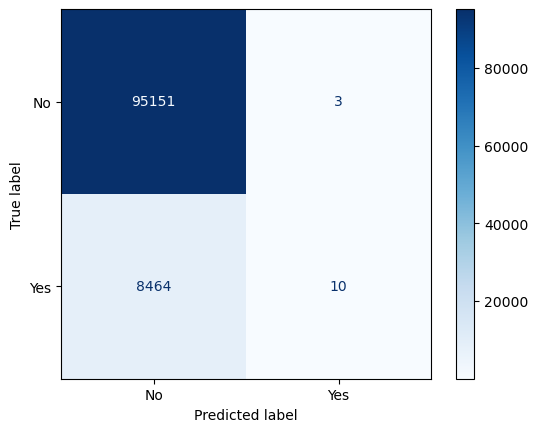

In [29]:
scores = []
scores.append(evaluation(X_test_ohe_imputed,y_test,preds1,rs))

### Oversample the minority class


In [30]:
pipe_oversample = ImbPipeline(steps = [
    ('sampling',RandomOverSampler(random_state = 42)),
    ('model',rs)
])

In [31]:
pipe_oversample.fit(X_train_ohe_imputed,y_train)

/Users/markbiernacki/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Pipeline(steps=[('sampling', RandomOverSampler(random_state=42)),
                ('model',
                 RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                                    param_distributions={'max_depth': [5],
                                                         'n_estimators': [100]},
                                    scoring='balanced_accuracy'))])

In [32]:
preds_oversample = pipe_oversample.predict(X_test_ohe_imputed)

balanced_accuracy: 0.7724445659555622
recall: 0.8270002360160491
precision: 0.20701878766394896
f1 score: 0.33114397769692394


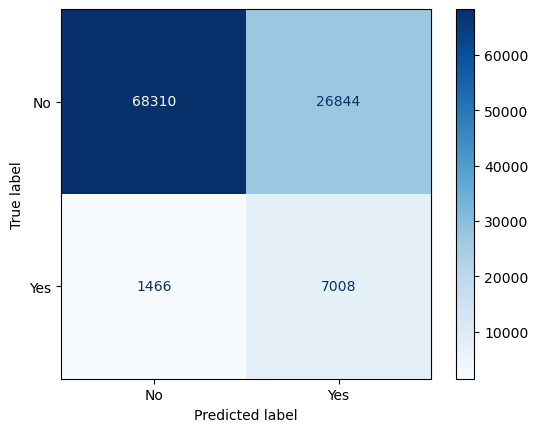

In [33]:
scores.append(evaluation(X_test_ohe_imputed,y_test,preds_oversample,pipe_oversample))

### SMOTE

In [35]:
pipe_smote = ImbPipeline(steps = [
    ('sampling',SMOTE(random_state = 42)),
    ('model',rs)
])

/Users/markbiernacki/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balanced_accuracy: 0.7016701790281716
recall: 0.515695067264574
precision: 0.290153376269836
f1 score: 0.37136180157212667


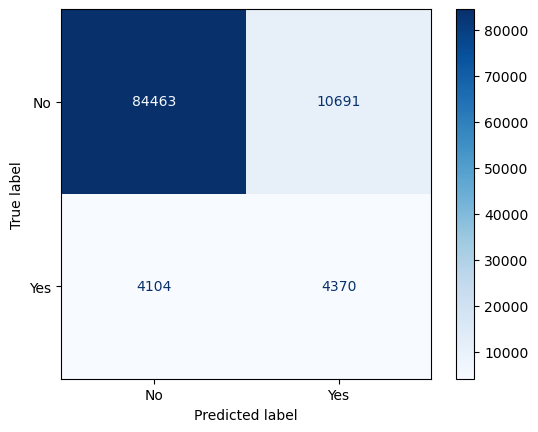

In [36]:
pipe_smote.fit(X_train_ohe_imputed,y_train)
preds_smote = pipe_smote.predict(X_test_ohe_imputed)
scores.append(evaluation(X_test_ohe_imputed,y_test,preds_smote,pipe_smote))

### ADASYN

In [37]:
pipe_adasyn = ImbPipeline(steps = [
    ('sampling',ADASYN(random_state = 42)),
    ('model',rs)
])

/Users/markbiernacki/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


balanced_accuracy: 0.6986576159966149
recall: 0.5062544253009205
precision: 0.2927128820960699
f1 score: 0.3709468223086901


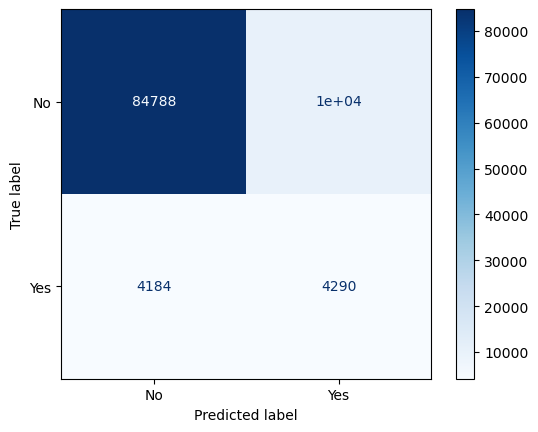

In [38]:
pipe_adasyn.fit(X_train_ohe_imputed,y_train)
preds_adasyn = pipe_adasyn.predict(X_test_ohe_imputed)
scores.append(evaluation(X_test_ohe_imputed,y_test,preds_adasyn,pipe_adasyn))